# Computing the betas

In order to compute the beta for both Stellantis and Walmart we took S&P 500 as benchmark.

To compute the beta for each company over the past 5 years, we will:

- Sort the data by date (in ascending order).

- Convert prices to monthly returns.

- Align returns by date across the 3 datasets.

- Perform linear regression of company returns on S&P 500 returns to compute beta.

### **Run Linear Regressions**

To estimate beta for each stock, we run an Ordinary Least Squares (OLS) regression of the stock's returns against the market returns (S&P 500). The regression equation is:

$$ r_{stock} = \alpha + \Beta \times r_{market} + \epsilon $$


Where:
- $r_{stock}$ is the return of the stock (e.g., Walmart or Stellantis)  
- $r_{market}$ is the return of the market (S&P 500)  
- $\beta$ represents the stock’s **systematic risk** (sensitivity to the market)  
- $\alpha$ is the intercept (often interpreted as abnormal return or "alpha")  
- $\epsilon$ is the error term  

The **slope coefficient (β)** from this regression is the **beta of the stock**. It tells us how much the stock’s return changes in response to changes in the market return.



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

# Load the datasets
walmart_df = pd.read_csv('Dataset/wmt_historical_data.csv')
stellantis_df = pd.read_csv('Dataset/stla_historical_data.csv')
sp500_df = pd.read_csv('Dataset/sp500_historical_data.csv')


We clean the data to run the regression to compute the beta for Stellantis and Walmart.

In [2]:

def clean_dataframe_for_beta(df):
    """
    Cleans the input DataFrame for Beta calculation.
    - Converts 'Close' to numeric, 'Date' to datetime.
    - Sorts by date.
    - Calculates monthly 'Return'.
    - KEEPS 'Date' as a column.
    """
    print(f"Initial DataFrame shape: {df.shape}")
    df['Close'] = df['Close'].astype(str).str.replace(',', '', regex=False)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)

    df['Date'] = pd.to_datetime(df['Date'].str[:-6], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)

    df.sort_values('Date', inplace=True)
    df['Return'] = df['Close'].pct_change()
    # DO NOT set index here
    return df

# Run the revised cleaning
walmart_df_beta = clean_dataframe_for_beta(walmart_df.copy()) 
stellantis_df_beta = clean_dataframe_for_beta(stellantis_df.copy())
sp500_df_beta = clean_dataframe_for_beta(sp500_df.copy())

print("\nDataFrames cleaned for Beta calculation (Date is a column).")

# CELL 128 (Keep as is - It will now work)
# Align the returns data by date using the _beta dataframes


Initial DataFrame shape: (60, 8)
Initial DataFrame shape: (60, 8)
Initial DataFrame shape: (60, 8)

DataFrames cleaned for Beta calculation (Date is a column).


In [3]:
returns_df = pd.merge(walmart_df_beta[['Date', 'Return']],
                      stellantis_df_beta[['Date', 'Return']],
                      on='Date', suffixes=('_Walmart', '_Stellantis'))
returns_df = pd.merge(returns_df,
                      sp500_df_beta[['Date', 'Return']],
                      on='Date')
returns_df.rename(columns={'Return': 'SP500'}, inplace=True)
returns_df.rename(columns={'Return_Walmart': 'Walmart'}, inplace=True)
returns_df.rename(columns={'Return_Stellantis': 'Stellantis'}, inplace=True)
returns_df.dropna(inplace=True)

# Store the returns in a CSV file for further analysis
returns_df.to_csv('Outputs/returns_data.csv', index=False)

In [4]:
X = returns_df[['SP500']].values

y_walmart = returns_df['Walmart'].values
beta_walmart = LinearRegression().fit(X, y_walmart).coef_[0]

y_stellantis = returns_df['Stellantis'].values
beta_stellantis = LinearRegression().fit(X, y_stellantis).coef_[0]

# Print the results
print("\n--- Beta Calculation Results ---")
print("Walmart Beta:", beta_walmart)
print("Stellantis Beta:", beta_stellantis)

# Store the betas in a file for CAPM calculations
betas_df = pd.DataFrame({
    'Company': ['Walmart', 'Stellantis'],
    'Beta': [beta_walmart, beta_stellantis]
})

betas_df.to_csv('Outputs/beta_results.csv', index=False)



--- Beta Calculation Results ---
Walmart Beta: 0.6732082074521727
Stellantis Beta: 1.5136297331477988


Mathematically, beta is the slope of the best-fit line (the red line) in a regression of stock returns (y-axis) vs market returns (x-axis). Hence, it is useful to visualize the relationship between the two sets of returns. The slope of the line is the beta, and the intercept is the alpha. A beta of 1 indicates that the stock moves in line with the market, while a beta greater than 1 indicates that the stock is more volatile than the market, and a beta less than 1 indicates that it is less volatile.

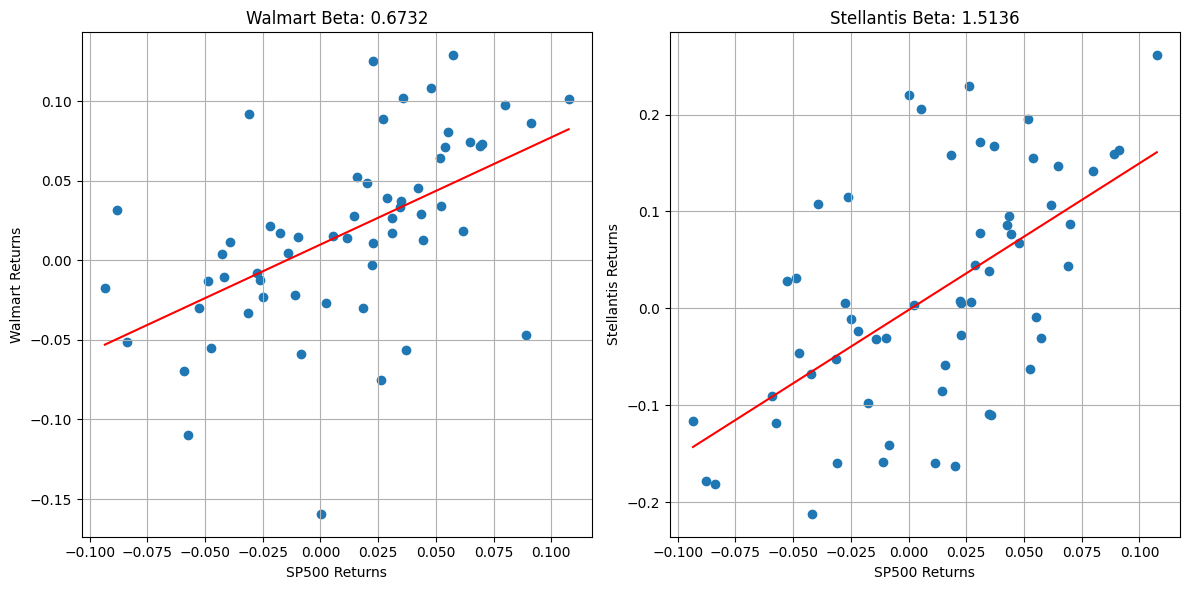

In [5]:
# Define risk-free rate (current 10-year Treasury yield as of April 2025)
risk_free_rate = 0.0427

# Calculate expected SP500 return (historical average plus risk premium)
market_risk_premium = 0.055  
expected_SP500_return = risk_free_rate + market_risk_premium


# Visualize the stock returns vs SP500 returns to see the beta relationship
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(returns_df['SP500'], returns_df['Walmart'])
plt.plot(np.unique(returns_df['SP500']), 
         np.poly1d(np.polyfit(returns_df['SP500'], returns_df['Walmart'], 1))(np.unique(returns_df['SP500'])), 
         color='red')
plt.xlabel('SP500 Returns')
plt.ylabel('Walmart Returns')
plt.title(f'Walmart Beta: {beta_walmart:.4f}')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(returns_df['SP500'], returns_df['Stellantis'])
plt.plot(np.unique(returns_df['SP500']), 
         np.poly1d(np.polyfit(returns_df['SP500'], returns_df['Stellantis'], 1))(np.unique(returns_df['SP500'])), 
         color='red')
plt.xlabel('SP500 Returns')
plt.ylabel('Stellantis Returns')
plt.title(f'Stellantis Beta: {beta_stellantis:.4f}')
plt.grid(True)

plt.tight_layout()
plt.savefig('stock_betas.png')
plt.show()



## 📉 Visual Interpretation of Beta: Walmart vs. Stellantis

The scatter plots above illustrate the **relationship between individual stock returns and market returns**, with the red line representing the **line of best fit** — essentially the **beta coefficient**.

### Walmart (Left Plot):
- The **beta is 0.6933**, as shown by the moderate slope of the trendline.
- This indicates **less sensitivity to market movements** — Walmart’s returns move **less than the market’s returns**.
- The data points are relatively clustered around the trendline, suggesting **stable and predictable performance**, typical of a **defensive stock** in consumer staples.

### Stellantis (Right Plot):
- The **beta is 1.5000**, reflected by the steeper slope.
- This shows **higher sensitivity to market changes** — when the market rises or falls, Stellantis tends to move **more aggressively in the same direction**.
- The spread of data points around the line is wider, reflecting **greater volatility**, which aligns with Stellantis being in the **cyclical automotive industry**.

### Summary:
- The visual evidence reinforces the CAPM calculations: **Walmart** is lower-risk with more stable returns, while **Stellantis** offers higher expected returns but at the cost of increased risk and volatility.


In [6]:
# Additionally, we can calculate R-squared to measure how well the market explains the stock variations
from scipy import stats

# For Walmart
slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['SP500'], returns_df['Walmart'])
walmart_rsquared = r_value**2

# For Stellantis
slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['SP500'], returns_df['Stellantis'])
stellantis_rsquared = r_value**2

print(f"\nWalmart R-squared: {walmart_rsquared:.4f}")
print(f"Stellantis R-squared: {stellantis_rsquared:.4f}")



Walmart R-squared: 0.2923
Stellantis R-squared: 0.3437


## Risk Interpretation:
### Walmart (β ≈ 0.72):

- Less volatile than the market.

- Considered a defensive stock. It tends to fluctuate less than the S&P 500.

- Suitable for risk-averse investors.

### Stellantis (β ≈ 1.42):

- More volatile than the market.

- Considered a cyclical stock. It tends to amplify market movements.

- May offer higher returns, but also higher risk.